# Regression

We use the same network architecture as the classification one, with the only difference that the last layer has now two output neurons (corresponding to the chirp mass and mass ratio predictions). The loss function is now the mean squared error, and we perform early stopping on the validation loss.

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import numpy as np 
from class_functions import *
import pandas as pd
import sklearn

np.random.seed(1234)
root_dir = "/home/alberto_sinigaglia/gaia"

In [7]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
def basic_block(x, kernel_size, filters, name, pool_size=2):
    """Single Conv1D layer with ReLU activation + global avarage pooling"""

    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-4), name=f'{name}_conv')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1, name=f"{name}_leaky_relu")(x)
    x = tf.keras.layers.AveragePooling1D(pool_size,  name=f'{name}_avgpooling')(x)
    return x
    
def residual_block(x, kernel_size, filters, name):

    shortcut = x 
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-4), name=f'{name}_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1, name=f"{name}_leaky_relu1")(x)
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation=None,  kernel_regularizer=tf.keras.regularizers.l2(1e-4), name=f'{name}_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name=f'{name}_bn2')(x)
    x = tf.keras.layers.Add( name=f'{name}_add')([shortcut, x])
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1, name=f"{name}_leaky_relu2")(x)
    return x

def build_model(input_length=6144, channels=1, filters=42):

    inp = tf.keras.layers.Input(shape=(input_length, channels), name='input_layer')

    x = basic_block(inp, 16, filters, name='bb_1')
    x = residual_block(x, 16, filters, name='rb_1')

    x = basic_block(x, 32, filters, name='bb_2')
    x = residual_block(x, 32, filters, name='rb_2')

    x = basic_block(x, 64, filters, name='bb_3')
    x =  residual_block(x, 64, filters, name='rb_3')

    x = basic_block(x, 64, filters, name='bb_4')

    #x = tf.keras.layers.Flatten(name='flatten_layer')(x)
    x = tf.keras.layers.GlobalAveragePooling1D(name='global_avg_pool')(x)

    #x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_1')(x)
    #x = tf.keras.layers.Dropout(0.2, name='dropout_1')(x)
    #x = tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_2')(x)
    #x = tf.keras.layers.Dropout(0.3, name='dropout_2')(x)
    x = tf.keras.layers.Dense(64,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_3')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout_1')(x)
    x = tf.keras.layers.Dense(32,  activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dl_4')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout_2')(x)

    out = tf.keras.layers.Dense(2, activation='linear', name='output_layer')(x)

    model =  tf.keras.Model(inp, out, name='regression_model')
    return model

model = build_model()
model.summary()

Model: "regression_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6144, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_1_conv (Conv1D)  │ (None, 6144, 42)  │        714 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_1_leaky_relu     │ (None, 6144, 42)  │          0 │ bb_1_conv[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_1_avgpooling     │ (None, 3072, 42)  │          0 │ bb_1_leaky_relu[… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_1_conv1 (Conv1D) │ (None, 3072, 42)  │     28,266 │ bb_1_avgpooling[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_1_bn1            │ (None, 3072, 42)  │        168 │ rb_1_conv1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_1_leaky_relu1    │ (None, 3072, 42)  │          0 │ rb_1_bn1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_1_conv2 (Conv1D) │ (None, 3072, 42)  │     28,266 │ rb_1_leaky_relu1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_1_bn2            │ (None, 3072, 42)  │        168 │ rb_1_conv2[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_1_add (Add)      │ (None, 3072, 42)  │          0 │ bb_1_avgpooling[… │
│                     │                   │            │ rb_1_bn2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_1_leaky_relu2    │ (None, 3072, 42)  │          0 │ rb_1_add[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_2_conv (Conv1D)  │ (None, 3072, 42)  │     56,490 │ rb_1_leaky_relu2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_2_leaky_relu     │ (None, 3072, 42)  │          0 │ bb_2_conv[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_2_avgpooling     │ (None, 1536, 42)  │          0 │ bb_2_leaky_relu[… │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_2_conv1 (Conv1D) │ (None, 1536, 42)  │     56,490 │ bb_2_avgpooling[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_2_bn1            │ (None, 1536, 42)  │        168 │ rb_2_conv1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_2_leaky_relu1    │ (None, 1536, 42)  │          0 │ rb_2_bn1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_2_conv2 (Conv1D) │ (None, 1536, 42)  │     56,490 │ rb_2_leaky_relu1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rb_2_bn2            │ (None, 1536, 42)  │        168 │ rb_2_conv2[0][0]

 Total params: 684,374 (2.61 MB)

 Trainable params: 683,870 (2.61 MB)

 Non-trainable params: 504 (1.97 KB)

In [9]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.96
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,  # Even lower
    decay_steps=500,
    decay_rate=0.95
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=5.0), 
              loss=tf.keras.losses.MeanSquaredError(),               
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])



## Low mass

The procedure followed will be the same for all the different mass ranges:
1. We load the data, filtering only the timeseries corresponding to GW events 
2. We build a tf dataset
3. We fit the model 
4. We plot the training-loss validation curves 
5. We plot the predicted vs true chirp mass 
6. We plot the predicted vs true mass ratio 

## Mid mass I

In [10]:
mass_range = "CNN_mid_mass_I"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

In [11]:
# load the data 

with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

mask = y[:,0] == 1 
X, y= X[mask], y[mask]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

In [12]:
# create the dataset 

train_dataset, train_scaler = make_dataset(X_train, y_train, classification=False, batch_size=64)
val_dataset, val_scaler = make_dataset(X_val, y_val, classification=False, batch_size=64)
test_dataset, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=64, shuffle=False)

In [13]:
model_path = f"reg_models/{mass_range}_best_model.keras"
logger_path = f"reg_models/training_log_{mass_range}.csv"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

In [14]:
history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/100
 5/91 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.2498 - rmse: 1.0962

I0000 00:00:1761580763.289771 2872670 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - loss: 1.0428 - rmse: 0.9979 - val_loss: 1.0656 - val_rmse: 1.0094
Epoch 2/100
 1/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.0223 - rmse: 0.9876

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.0254 - rmse: 0.9893 - val_loss: 1.2422 - val_rmse: 1.0935
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.9880 - rmse: 0.9703 - val_loss: 1.1325 - val_rmse: 1.0422
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.8796 - rmse: 0.9128 - val_loss: 1.6116 - val_rmse: 1.2511
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.8053 - rmse: 0.8712 - val_loss: 1.0590 - val_rmse: 1.0063
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.7566 - rmse: 0.8428 - val_loss: 0.9397 - val_rmse: 0.9452
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.7201 - rmse: 0.8209 - val_loss: 1.0121 - val_rmse: 0.9828
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.6865 - rmse: 0.8002 - val_loss: 0.8741 - val_rmse: 0.9099
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.6639 - rmse: 0.7860 - val_loss: 0.7153 - val_rmse: 0.8181
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step

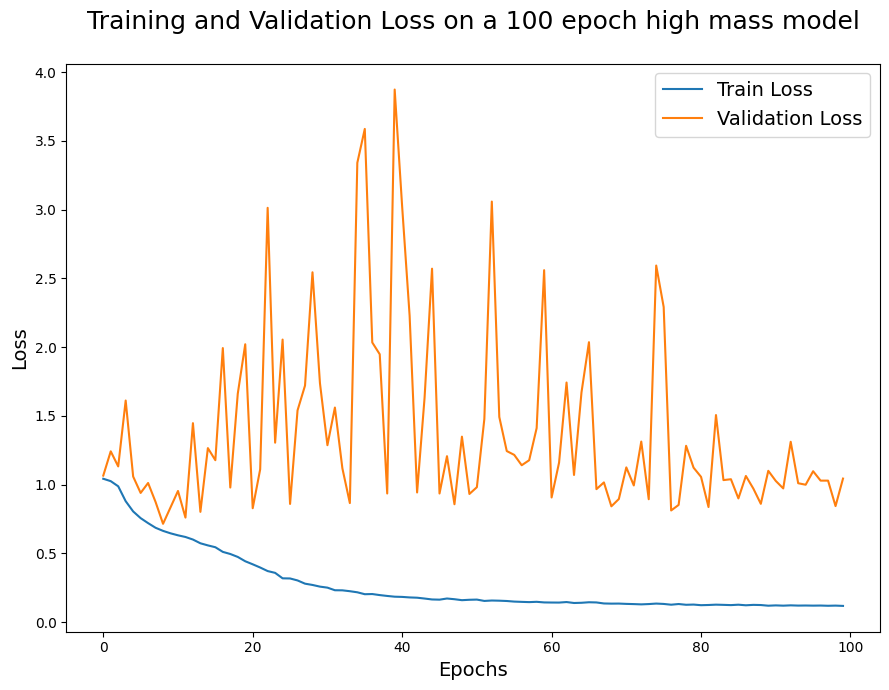

In [15]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.title('Training and Validation Loss on a 100 epoch high mass model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [11]:
model = tf.keras.models.load_model(model_path)
mse, rmse = model.evaluate(test_dataset)
y_pred = model.predict(X_test)
y_pred = test_scaler.inverse_transform(y_pred)

true_M = y_test[:,1].astype(np.float64)
pred_M = y_pred[:,0]

true_q = y_test[:,2].astype(np.float64)
pred_q = y_pred[:,1]

print(f"Test MSE: {mse}, Test RMSE: {rmse}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.8140 - rmse: 0.8743
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Test MSE: 0.8139532804489136, Test RMSE: 0.8743157982826233


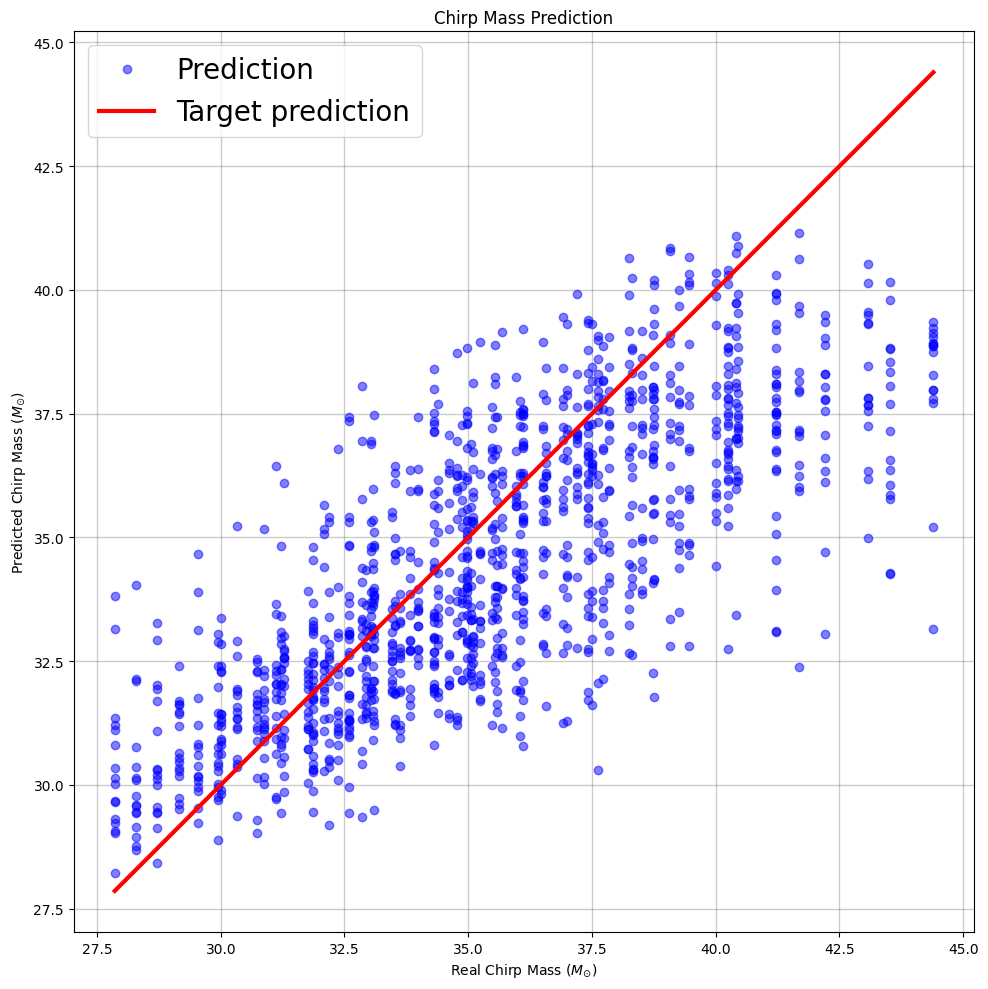

In [13]:
plot_chirp_mass(true_M, pred_M, 'Chirp Mass Prediction')

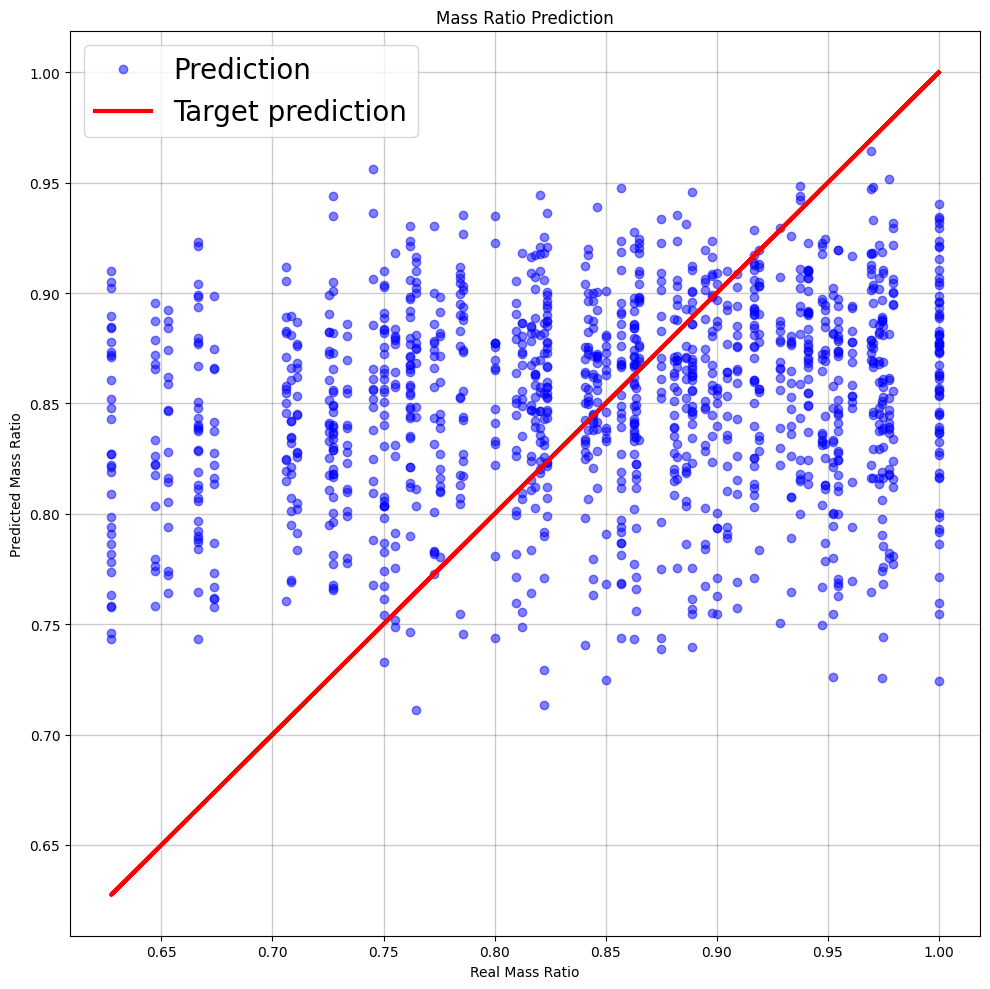

In [14]:
plot_mass_ratio(true_q, pred_q, 'Mass Ratio Prediction')

## Mid mass II

## High mass

In [ ]:
mass_range = "CNN_high_mass"

train_path = f"{root_dir}/{mass_range}_train.npz"
test_path = f"{root_dir}/{mass_range}_test.npz"

with np.load(train_path, allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]

mask = y[:,0] == 1
X, y= X[mask], y[mask]

X_train, X_val, y_train, y_val = split_train_val(X, y, val_size=0.2)

with np.load(test_path, allow_pickle=True) as data:
    X_test = data["X"]
    y_test = data["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]


In [ ]:
train_dataset = make_dataset(X_train, y_train, classification=False, batch_size=64)
val_dataset = make_dataset(X_val, y_val, classification=False, batch_size=64)
test_dataset = make_dataset(X_test, y_test, classification=False, batch_size=64, shuffle=False)

In [6]:
model_path = f"reg_models/{mass_range}_best_model.keras"
logger_path = f"reg_models/training_log_{mass_range}.csv"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, 
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=0,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename=logger_path,
        append=False,
    )
]

In [7]:
history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=350,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/350


 5/91 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3186.7961 - rmse: 55.8079

I0000 00:00:1761556988.563505 1797980 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 1072.8612 - rmse: 30.9588

/home/alberto_sinigaglia/anaconda3/envs/gaia/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 168ms/step - loss: 421.8135 - rmse: 20.5359 - val_loss: 158.2971 - val_rmse: 12.5780
Epoch 2/350
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 73.7192 - rmse: 8.5807 - val_loss: 882.9180 - val_rmse: 29.7124
Epoch 3/350
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 57.9886 - rmse: 7.6090 - val_loss: 1135.0936 - val_rmse: 33.6898
Epoch 4/350
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 51.4349 - rmse: 7.1655 - val_loss: 1081.4337 - val_rmse: 32.8838
Epoch 5/350
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 46.6383 - rmse: 6.8225 - val_loss: 711.7992 - val_rmse: 26.6779
Epoch 6/350
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 41.6178 - rmse: 6.4441 - val_loss: 229.0930 - val_rmse: 15.1328
Epoch 7/350
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 40.5126 - rmse: 6.3578 - val_loss: 662.2905 - val_rmse: 25.7332
Epoch 8/350
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 40.2068 - rmse: 6.3337 - val_loss: 767.4532 - val_rmse: 27.7013
Epoch 9/350
91

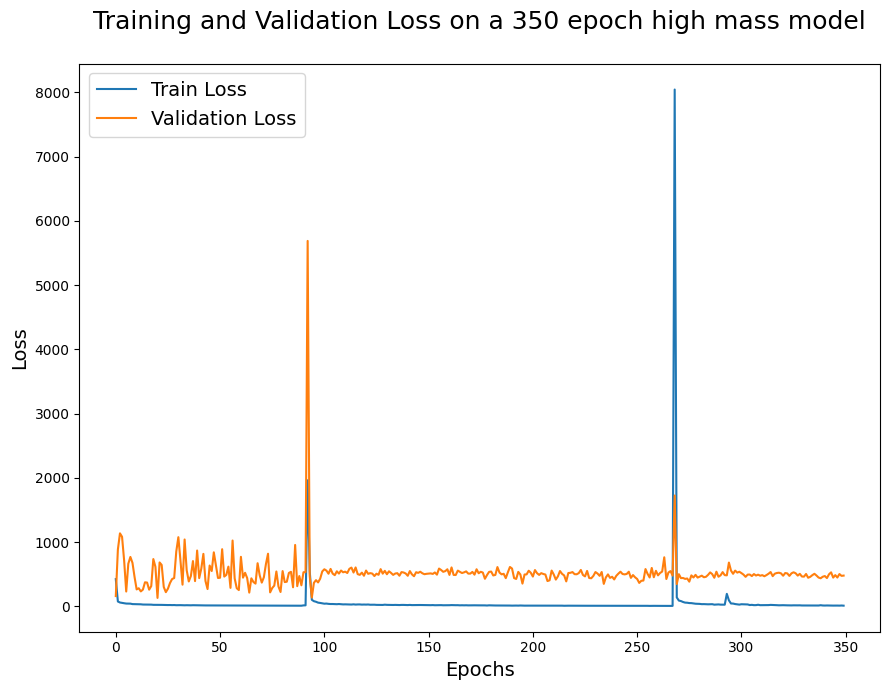

In [7]:
logger = pd.read_csv(logger_path)
train_loss = logger['loss'].values
val_loss = logger['val_loss'].values

plt.figure(figsize=(9,7))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.title('Training and Validation Loss on a 350 epoch high mass model',
          fontsize=18, pad=25)

plt.legend(fontsize=14, loc='best')

plt.tight_layout()
plt.show()

In [ ]:
model = tf.keras.models.load_model(model_path)
Y_pred = model.predict(X_test)

30/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

I0000 00:00:1761559272.546292 2007743 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step
